# Imports

In [49]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0
from fastai.vision import *
from fastai.vision.learner import model_meta
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score

PATH = Path('/home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection')
TRAIN_NAME = 'train'
TRAIN = PATH/TRAIN_NAME
CSV_NAME = 'train_labels.csv'
LABELS = PATH/CSV_NAME
TEST_NAME = 'test'
TEST = PATH/TEST_NAME
SAMPLE = PATH/'sample_submission.csv'
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

TRAIN_LR_NAME = 'train_lr'
TRAIN_LR = PATH/TRAIN_LR_NAME

nw = 8   #number of workers for data loader
torch.backends.cudnn.benchmark=True
seed = 42
np.random.seed(seed)

def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
        "Grab a batch of data and call reduction function `func` per channel"
        funcs = ifnone(funcs, [torch.mean,torch.std])
        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
        return [func(channel_view(x), 1) for func in funcs]
    
    
vision.data.ImageDataBunch.batch_stats = batch_stats

sz = 96
bs = 128
epochs_freezed = 1
epochs_unfreezed = 20

#fastai defaults
tta_beta = 0.4 
tta_scale = 1.35
dropout = 0.5
wd = 0.01

#non defaults


# Crappify images

In [34]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn
        img = PIL.Image.open(self.path_hr/fn)
        targ_sz = resize_to(img, 48, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        q = random.randint(10,70)
        img.save(dest, quality=q)

In [27]:
fnames = [os.path.split(p)[-1] for p in list(TRAIN.iterdir())]

In [42]:
parallel(crappifier(TRAIN_LR, TRAIN), fnames)

# Data

In [54]:
src = ImageImageList.from_folder(TRAIN_LR).split_by_rand_pct(0.1, seed=seed)

In [55]:
tfms = ([crop(size=sz),
        RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
      #RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
     [crop(size=sz)])

In [56]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: TRAIN/x.name)
           .transform(tfms, size=size, tfm_y=True)
           .databunch(bs=bs).normalize(do_y=True))

    data.c = 2
    return data

In [58]:
data_gen = get_data(bs,sz)

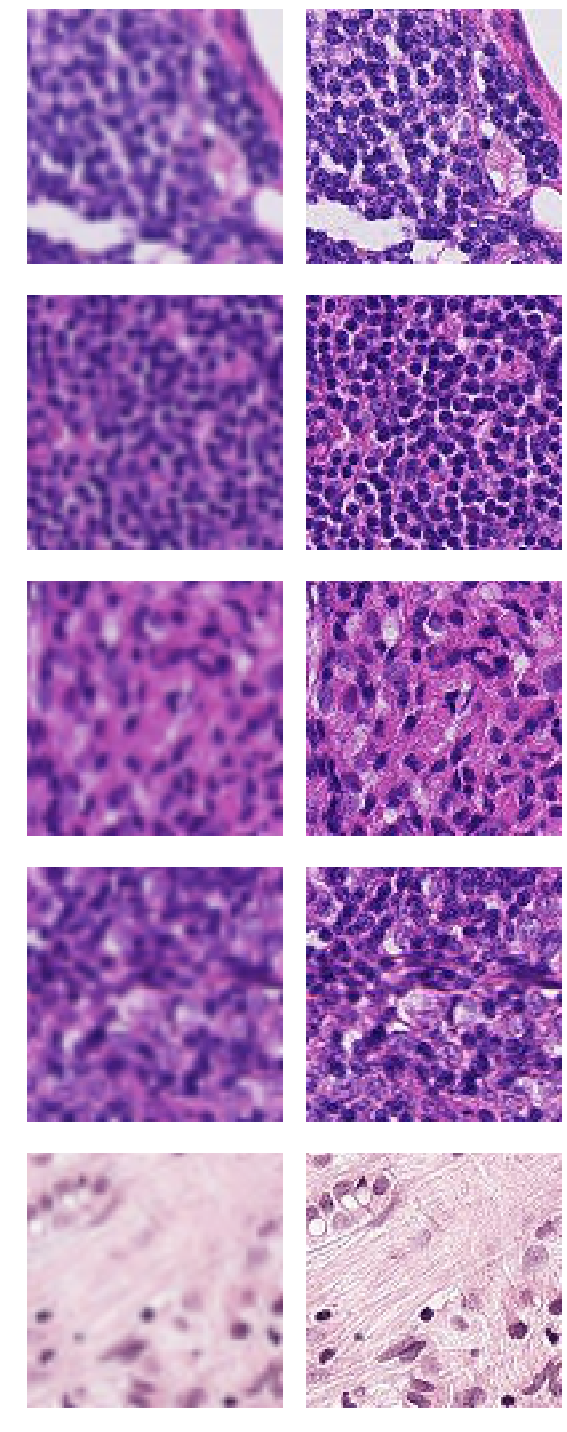

In [59]:
data_gen.show_batch()

# Learner

In [60]:
arch = torchvision.models.resnet34

wd = 1e-3

y_range = (-3.,3.)

loss_gen = MSELossFlat()

def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/Deep_Learner/.torch/models/resnet34-333f7ec4.pth
87306240it [00:07, 11081512.12it/s]


In [61]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.192559,0.193856,11:51


KeyboardInterrupt: 